In [1]:
# export
import fastbook
fastbook.setup_book()

In [2]:
# export
from fastai.vision.all import *
from fastbook import *

In [3]:
# export
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

(#2) [Path('/home/john/.fastai/data/mnist_png/testing'),Path('/home/john/.fastai/data/mnist_png/training')]

In [5]:
(path/'training').ls()

(#10) [Path('/home/john/.fastai/data/mnist_png/training/7'),Path('/home/john/.fastai/data/mnist_png/training/6'),Path('/home/john/.fastai/data/mnist_png/training/2'),Path('/home/john/.fastai/data/mnist_png/training/4'),Path('/home/john/.fastai/data/mnist_png/training/0'),Path('/home/john/.fastai/data/mnist_png/training/5'),Path('/home/john/.fastai/data/mnist_png/training/9'),Path('/home/john/.fastai/data/mnist_png/training/1'),Path('/home/john/.fastai/data/mnist_png/training/3'),Path('/home/john/.fastai/data/mnist_png/training/8')]

In [6]:
im0 = Image.open(path/'training'/'0'/'4356.png')
im0

In [7]:
# im0_t = tensor(im0)
# df = pd.DataFrame(im0_t)
# df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Blues')

In [8]:
# export 

def stack(dir):
    return torch.stack([tensor(Image.open(f)) for f in dir.ls()]).float()/255

samples = [tensor(Image.open(files.ls()[0])) for files in (path/'training').ls().sorted()]
stacks = [stack(dir) for dir in (path/'training').ls().sorted()]
means = [s.mean(0) for s in stacks]

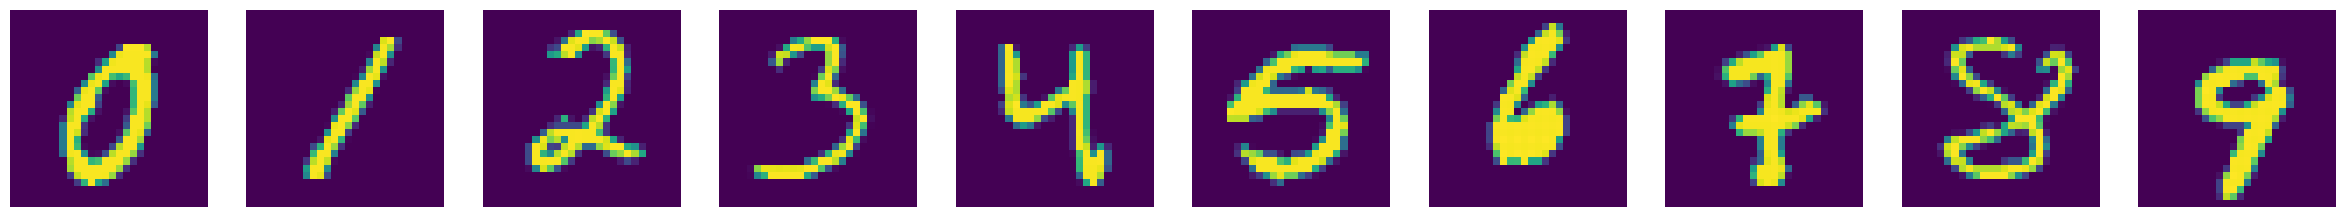

In [9]:
show_images(samples)

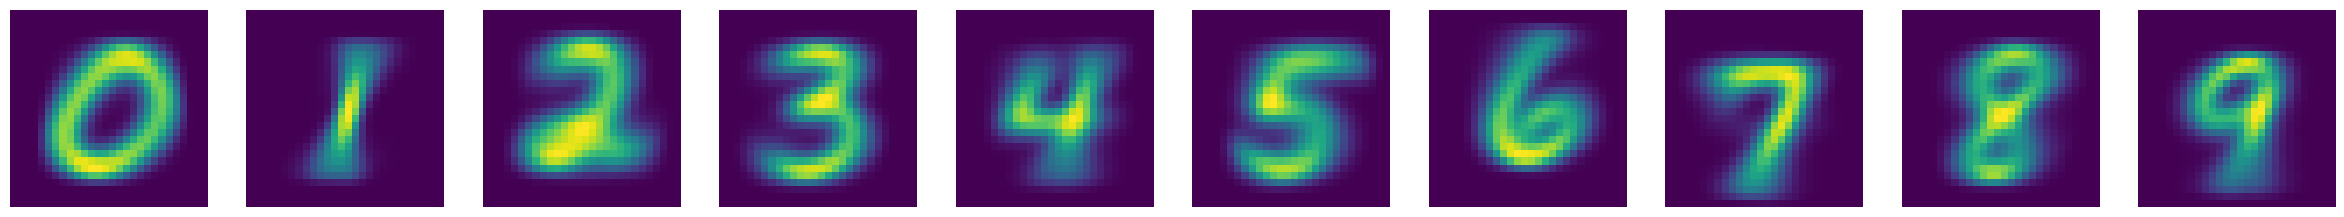

In [10]:
show_images(means, nrows=1)

In [11]:
#df = pd.DataFrame(means[0])
#df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

In [12]:
# export 
def mnist_distance(a,b):
    return (a-b).abs().mean((-1,-2))

In [13]:
# export
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

def scores(sample):
    return [mnist_distance(sample, mean) for mean in means] 

import numpy as np
def classify(scores):
    return labels[np.argmin(scores)]


In [14]:
samples = [tensor(Image.open(files.ls()[8])) for files in (path/'training').ls().sorted()]
print( [classify(scores(sample)) for sample in samples] )

['0', '1', '2', '3', '9', '3', '6', '9', '8', '9']


In [24]:
# export
# Transform from list of matrices to list of arrays
train_x = torch.cat(stacks).view(-1, 28*28)
def filecount(dir):
    return len(dir.ls())
train_y = torch.cat([tensor([i]*filecount(path/'training'/f'{i}')) for i in range(10)]).unsqueeze(1)

In [47]:
# export
valid_stacks = [stack(dir) for dir in (path/'testing').ls().sorted()]
valid_x = torch.cat(valid_stacks).view(-1, 28*28)
valid_y = torch.cat([tensor([i]*filecount(path/'testing'/f'{i}')) for i in range(10)]).unsqueeze(1)

In [48]:
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)

torch.Size([60000, 784]) torch.Size([60000, 1]) torch.Size([10000, 784]) torch.Size([10000, 1])


In [49]:
# export
dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))

In [40]:
# export 
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [43]:
# export
weights = init_params((28*28,1))
bias = init_params(1)

In [50]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [46]:
xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [51]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [52]:
# export
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 
                       
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [53]:
calc_grad(batch, train_y[:4], linear1)

NameError: name 'mnist_loss' is not defined

In [17]:
import nbformat

def export_cells(notebook_path, export_path, directive="# export"):
    with open(notebook_path, 'r') as f:
        notebook = nbformat.read(f, as_version=4)

    script_lines = []
    script_lines.append("# Generated by the corresponding notebook.")
    for cell in notebook.cells:
        if cell.cell_type == "code":
            if cell.source.startswith(directive):
                # Remove the first line (the directive itself)
                cleaned_source = "\n".join(cell.source.split("\n")[1:])
                script_lines.append(cleaned_source)

    with open(export_path, 'w') as f:
        f.write("\n\n".join(script_lines))

# Usage
export_cells("main.ipynb", "main.py")
